In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import george
from george.modeling import Model
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, dipole

In [3]:
sys.path.insert(0, '/home/aew492/CFE_gradients/funcs')
from convert_xyz_data import xyz_to_thetaphi, xyz_to_radec

#### functions

In [8]:
def plot_map(map, projection_type='mollweide', coord=['C'],
             graticule=True, graticule_labels=True, **kwargs):
    projview(map, projection_type=projection_type, coord=coord,
             graticule=graticule, graticule_labels=graticule_labels, **kwargs)

In [9]:
def flatten_map(sf_map):
    newarr = np.array([row[0] for row in sf_map])
    return np.reshape(newarr, (newarr.size,))

#### parameters

In [10]:
mapdir = '/scratch/aew492/quasars/maps'
NSIDE = 64
G = 20.5

### selection function without dipole

In [11]:
sf_nodip_tab = Table.read(os.path.join(mapdir, f'selection_function_NSIDE{NSIDE}_G{G}.fits'), format='fits')
selfunc_nodip = flatten_map(sf_nodip_tab)

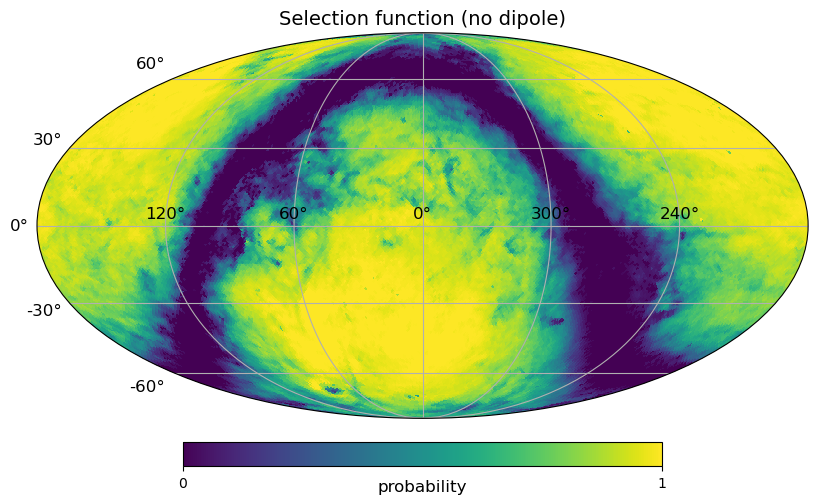

In [12]:
plot_map(selfunc_nodip, title='Selection function (no dipole)', unit='probability')

### selection function with dipole

In [13]:
sf_fn = f'selection_function_NSIDE{NSIDE}_G{G}_dipole'
sf_dip_tab = Table.read(os.path.join(mapdir, f'{sf_fn}.fits'), format='fits')
selfunc_dip = flatten_map(sf_dip_tab)

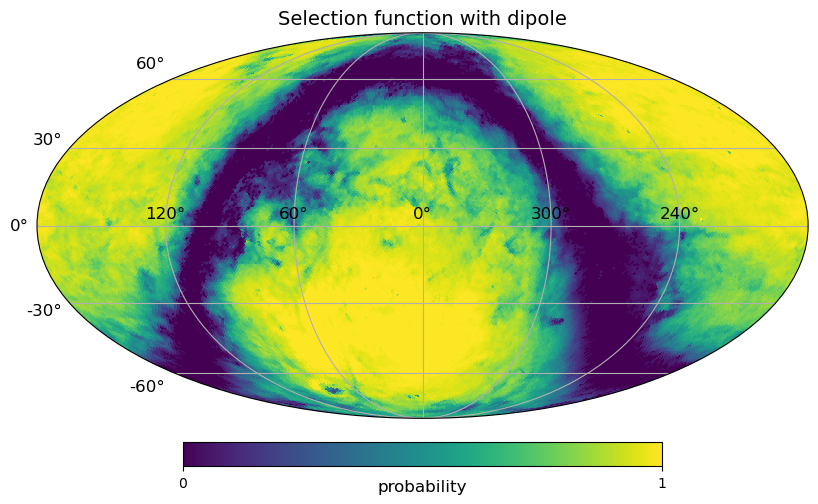

In [14]:
plot_map(selfunc_dip, title='Selection function with dipole', unit='probability')

In [15]:
# residuals
fit_idx = np.where(selfunc_dip > 0)
res = selfunc_dip[fit_idx] - selfunc_nodip[fit_idx]
len(fit_idx[0])

42853

Text(0.5, 1.0, 'Selection function (dipole - no dipole) (42853 pixels)')

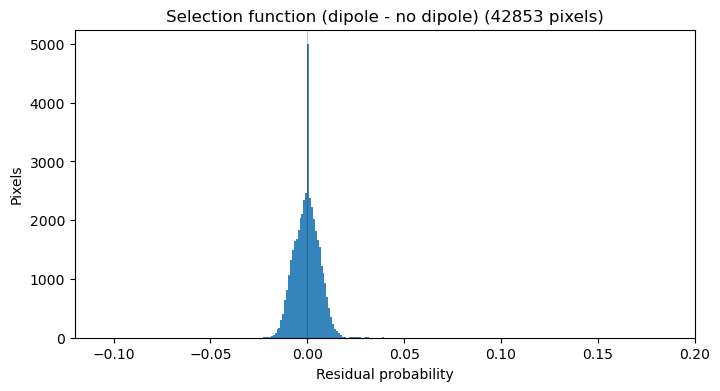

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
_, _, _ = ax.hist(res, bins=130, alpha=0.9)
ax.axvline(0, color='k', lw=0.5, alpha=0.3)
ax.set_xlim((-.12,.2))
ax.set_xlabel('Residual probability')
ax.set_ylabel('Pixels')
ax.set_title(f'Selection function (dipole - no dipole) ({len(fit_idx[0])} pixels)')

/state/partition1/job-34875917/ipykernel_3776697/3709874337.py:1: RuntimeWarning: invalid value encountered in divide
  plot_map(selfunc_dip / selfunc_nodip, title='Residuals (dipole / no dipole)', min=0.85, max=1.15)


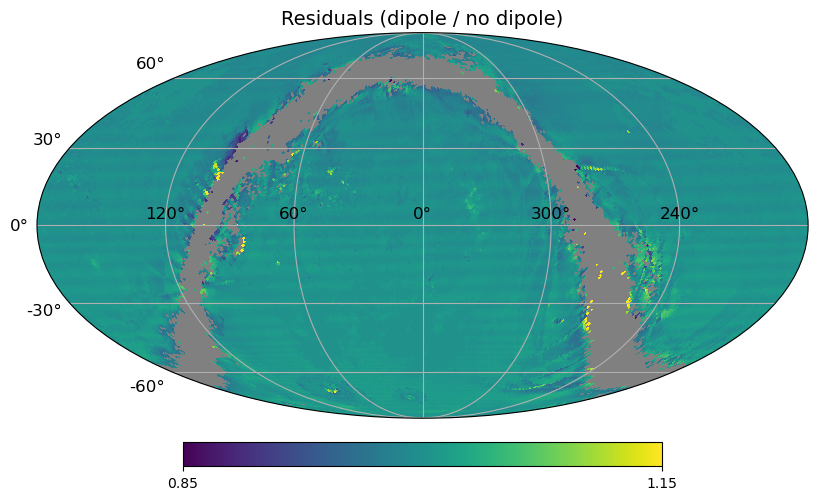

In [20]:
plot_map(selfunc_dip / selfunc_nodip, title='Residuals (dipole / no dipole)', min=0.85, max=1.15)

In [21]:
# check dipole optimization result
result = np.load(os.path.join(mapdir, f'{sf_fn}-res.npy'), allow_pickle=True).item()
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5178.768239538902
        x: [ 1.941e+00 -4.680e-03  1.541e-03 -1.483e-02 -2.731e-01
             1.374e+00 -3.878e+00  5.259e+00]
      nit: 19
      jac: [-1.871e-08 -1.205e-07 -1.804e-06  1.207e-06  4.566e-08
            -5.155e-08 -4.604e-08  1.782e-08]
 hess_inv: [[ 4.706e-02  2.377e-07 ... -6.767e-03 -5.722e-03]
            [ 2.377e-07  2.114e-06 ...  1.203e-06 -1.383e-06]
            ...
            [-6.767e-03  1.203e-06 ...  3.848e-02 -5.526e-03]
            [-5.722e-03 -1.383e-06 ... -5.526e-03  2.120e-01]]
     nfev: 33
     njev: 33

In [22]:
amps_quaia = result.x[:4]
amps_quaia

array([ 1.94055916e+00, -4.68038723e-03,  1.54053889e-03, -1.48322265e-02])

In [23]:
# amplitude and direction
dipoleamp = np.linalg.norm(amps_quaia[1:])
print(f"dipole amplitude = {dipoleamp:.6f}")
theta, phi = xyz_to_thetaphi(amps_quaia[1:])*u.radian
print(f"theta = {theta:.4f}, phi = {phi:.4f} --> theta = {theta.to('deg'):.2f}, phi = {phi.to('deg'):.2f}")
print("in equatorial coordinates!")

dipole amplitude = 0.015629
theta = 2.8236 rad, phi = 2.8209 rad --> theta = 161.78 deg, phi = 161.62 deg
in equatorial coordinates!


### Coordinate stuff:
- my `xyz_to_thetaphi()` outputs $(\theta=\mathrm{LAT},\phi=\mathrm{LON})\ \rightarrow\ \mathrm{LON}\in [-\pi,\pi]\ ,\ \mathrm{LAT}\in [0,\pi]$
    - $\phi=0$ at the north pole
- `SkyCoord()` takes in $(\mathrm{LON}, \mathrm{LAT})$, $\mathrm{LAT}\in [-\pi/2,\pi/2]$, outputs $\rightarrow\ \mathrm{LON}\in [0,2\pi]\ ,\ \mathrm{LAT}\in [-\pi/2,\pi/2]$
    - $\mathrm{LAT}=0$ at the celestial equator
- `healpy` takes in $(\mathrm{LAT}, \mathrm{LON})$
    - $\mathrm{LAT}=0$ at the north pole
    - `newprojplot()`: any LON not in $[-\pi,\pi]$ is off the map; any LAT < 0 or > $\pi$ is visible "behind" the map

`SkyCoord()` sets LAT=0 at the equator instead of the north pole, so shift the coordinate when we input:

In [19]:
dip_quaia = SkyCoord(theta, np.pi/2*u.rad-phi, unit=u.rad, frame='icrs')
print(dip_quaia)

<SkyCoord (ICRS): (ra, dec) in deg
    (161.78115652, -71.62304039)>


In [20]:
# CMB dipole (from Planck2020)
dip_cmb = SkyCoord(264.021, 48.253, unit=u.deg, frame='galactic')
dip_cmb.galactic

<SkyCoord (Galactic): (l, b) in deg
    (264.021, 48.253)>

#### sanity checks

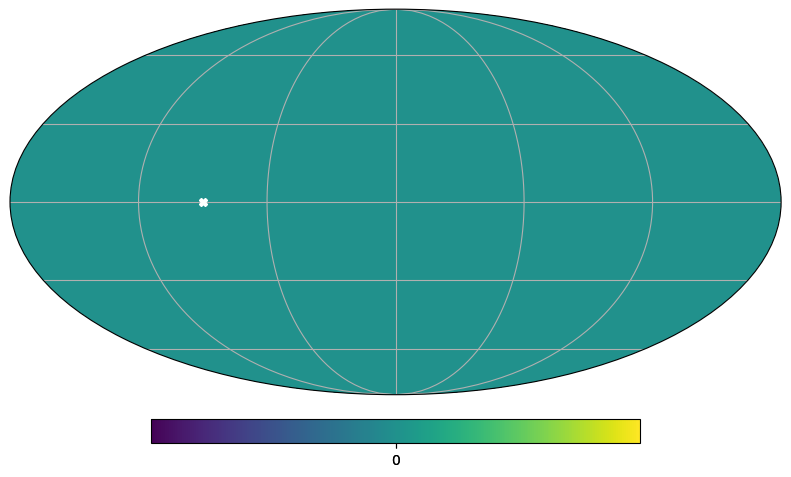

In [21]:
# test newprojplot
# background (no dipole)
testamps = [0,0,0,0]
projview(dipole_map(testamps), coord=['G'], projection_type='mollweide', graticule=True)

phi = np.pi/2
theta = np.pi/2
newprojplot(phi, theta, marker='X', color='white')

theta = 0.79 rad, phi = 0.96 rad


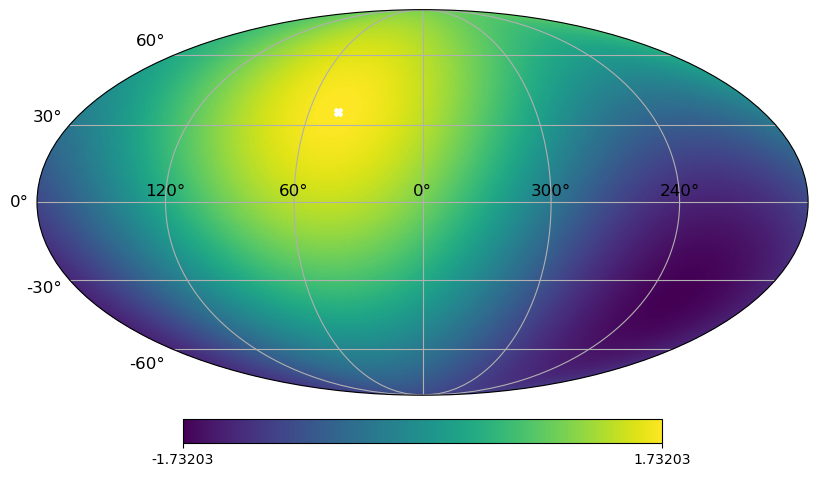

In [34]:
# sanity check on dipole amplitudes
testamps = [0,1,1,1]
# plot dipole contribution at each point on the map
projview(dipole_map(testamps), projection_type='mollweide', graticule=True, graticule_labels=True)
# plot coordinate
theta, phi = xyz_to_thetaphi(testamps[1:])*u.radian
print(f"theta = {theta:.2f}, phi = {phi:.2f}")
newprojplot(phi, theta, marker='X', color='white')

#### recovered QUaia dipole

QUaia dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (161.78115652, -71.62304039)>
monopole, dipole amps:  [ 1.94055916e+00 -4.68038723e-03  1.54053889e-03 -1.48322265e-02]
QUaia (theta, phi) = (2.82 rad, 2.82 rad)

CMB dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (167.94190333, -6.94425998)>
CMB (theta, phi) = (2.93 rad, 1.45 rad)

xyz axes:
[1. 0. 0.], (theta, phi) = (0.00 rad, 1.57 rad)
[0. 1. 0.], (theta, phi) = (1.57 rad, 1.57 rad)
[0. 0. 1.], (theta, phi) = (0.00 rad, 0.00 rad)


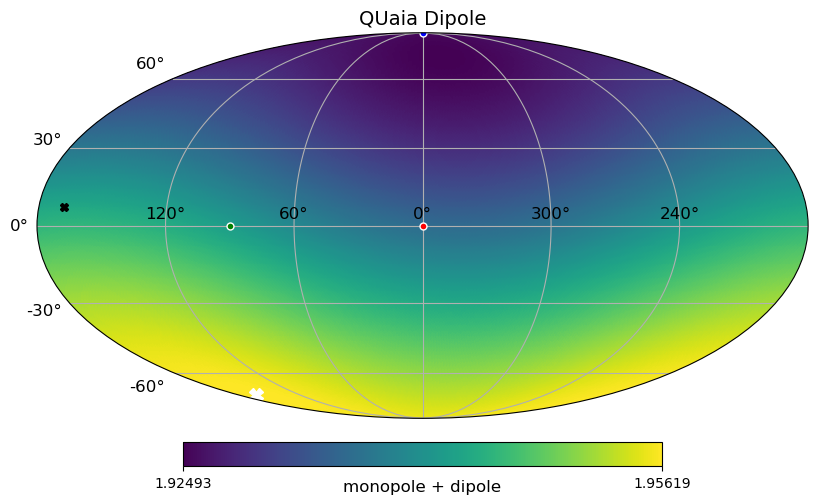

In [32]:
projview(dipole_map(amps_quaia), projection_type='mollweide',
        graticule=True, graticule_labels=True, title='QUaia Dipole', unit='monopole + dipole')
print("QUaia dipole: ", dip_quaia.icrs)
print("monopole, dipole amps: ", amps_quaia)
theta_quaia, phi_quaia = xyz_to_thetaphi(amps_quaia[1:])*u.radian
print(f"QUaia (theta, phi) = ({theta_quaia:.2f}, {phi_quaia:.2f})")
newprojplot(phi_quaia, theta_quaia, marker='X', color='white', ms=10)

# CMB dipole
print("\nCMB dipole: ", dip_cmb.icrs)
print(f"CMB (theta, phi) = ({dip_cmb.icrs.ra.to('rad'):.2f}, {dip_cmb.icrs.dec.to('rad')+np.pi/2*u.rad:.2f})")
newprojplot(dip_cmb.icrs.dec.rad+np.pi/2, dip_cmb.icrs.ra.rad, marker='X', color='k', label='CMB')

# plot (x,y,z) axes for reference
print("\nxyz axes:")
cs = ['r', 'g', 'b']
for i, unit_vec in enumerate(np.identity(3)):
    theta, phi = xyz_to_thetaphi(unit_vec)*u.radian
    print(f"{unit_vec}, (theta, phi) = ({theta:.2f}, {phi:.2f})")
    newprojplot(phi, theta, marker='.', color=cs[i], ms=10, markeredgecolor='white')

monopole, dipole amps:  [0, 1, 0, 0]
QUaia (theta, phi) = (0.00 rad, 1.57 rad)

CMB dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (167.94190333, -6.94425998)>
CMB (theta, phi) = (2.93 rad, 1.45 rad)

xyz axes:
[1. 0. 0.], (theta, phi) = (0.00 rad, 1.57 rad)
[0. 1. 0.], (theta, phi) = (1.57 rad, 1.57 rad)
[0. 0. 1.], (theta, phi) = (0.00 rad, 0.00 rad)


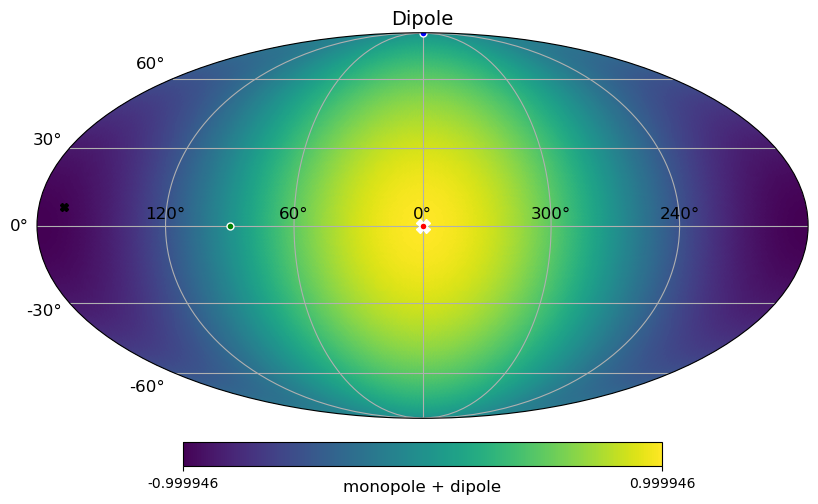

In [37]:
amps = [0,1,0,0]
projview(dipole_map(amps), projection_type='mollweide',
        graticule=True, graticule_labels=True, title='Dipole', unit='monopole + dipole')
print("monopole, dipole amps: ", amps)
theta, phi = xyz_to_thetaphi(amps[1:])*u.radian
print(f"QUaia (theta, phi) = ({theta:.2f}, {phi:.2f})")
newprojplot(phi, theta, marker='X', color='white', ms=10)

# CMB dipole
print("\nCMB dipole: ", dip_cmb.icrs)
print(f"CMB (theta, phi) = ({dip_cmb.icrs.ra.to('rad'):.2f}, {dip_cmb.icrs.dec.to('rad')+np.pi/2*u.rad:.2f})")
newprojplot(dip_cmb.icrs.dec.rad+np.pi/2, dip_cmb.icrs.ra.rad, marker='X', color='k', label='CMB')

# plot (x,y,z) axes for reference
print("\nxyz axes:")
cs = ['r', 'g', 'b']
for i, unit_vec in enumerate(np.identity(3)):
    theta, phi = xyz_to_thetaphi(unit_vec)*u.radian
    print(f"{unit_vec}, (theta, phi) = ({theta:.2f}, {phi:.2f})")
    newprojplot(phi, theta, marker='.', color=cs[i], ms=10, markeredgecolor='white')

In [29]:
dip_quaia.galactic

<SkyCoord (Galactic): (l, b) in deg
    (293.38570661, -11.09405002)>

In [30]:
# compare dipole amplitudes
D_cmb = .0072
D_quaia = dipoleamp
print(D_quaia/D_cmb)

2.17073259687834
